## A Quick Summary of this Notebook
This notebook is used to compare and contrast regression models, scatter plots, and pure raw data calculated from the updated Radiation component. We can test the reliability of the new radiation model by comparing its results against observed incident radiation from an actual corn field in Bondville, collected over an entire year.

In [1]:
import numpy as np
import xlrd
from landlab.components import Radiation     # radiation component

from landlab import RasterModelGrid
from landlab.components import PotentialEvapotranspiration    #Potential Evapotranspiration component 

from landlab.io import read_esri_ascii
from landlab.plot import imshow_grid
from landlab.plot.video_out import VideoPlotter

%matplotlib inline


#from landlab.plot.imshow import imshow_grid
import matplotlib.pyplot as plt

plt.show()

Read an existing esri grid as watershed and map the elevation field

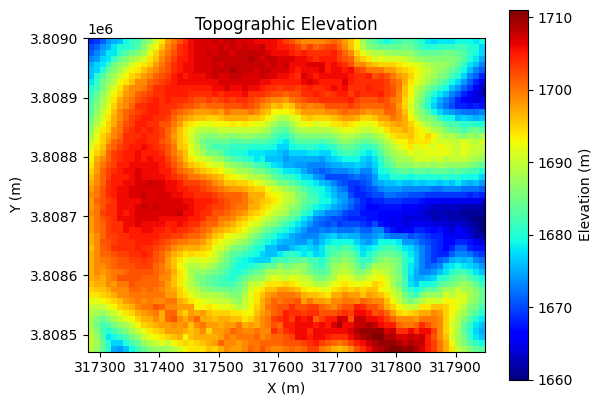

In [2]:
(watershed,z)=read_esri_ascii('Hugo_ws_10m.asc', name='topographic__elevation')
    
plt.figure()
imshow_grid(watershed,'topographic__elevation', plot_name = 'Topographic Elevation', 
            var_name = 'Elevation', var_units = 'm', grid_units = ('m','m'), 
            cmap = 'jet')

### UPDATED RADIATION COMPONENT MODEL TESTING
#### Let's run some tests on the updated Radiation component and analyze the results of the tests. We will be using the Bondville, IL experiment results and data to generate predicted shortwave radiation values using the Radiation component, and then comparing the component-generated results with the known radiation values to examine model accuracy.

Create an instance of Radiation "rad" and feed Bondville experiment variable fields for better calculation. 0.5 time is for June / summertime

c:\Users\Berkan\mambaforge\envs\landlab-dev-install\Lib\site-packages\matplotlib\colors.py:1403: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
c:\Users\Berkan\mambaforge\envs\landlab-dev-install\Lib\site-packages\matplotlib\colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


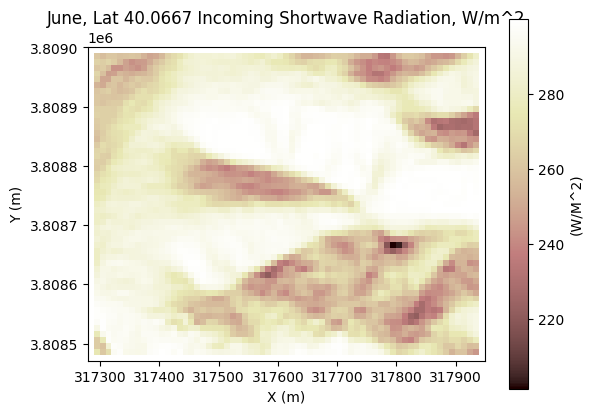

In [3]:
# 0.5 represents around June or summer
rad = Radiation(watershed, method='Grid', latitude=40.0667, albedo=0.12,  current_time=0.5, opt_airmass=2.0, clearsky_turbidity=2.0)
rad._Tavg = 20.0
plt.figure()

rad.update()
imshow_grid(watershed, 'radiation__incoming_shortwave_flux', values_at='cell',
                plot_name='June, Lat 40.0667 Incoming Shortwave Radiation, W/m^2', var_units='W/M^2', grid_units=('m','m'))


Now create and populate two lists using the Excel file with all the Bondville, IL radiation field data. One list (field_plot) will store the 
radiation data listed in the Bondville spreadsheets, while the other (calculated_plot) will store radiation data calculated from input / experimental
variables provided by the Bondville spreadsheets that do NOT include the values of observed/measured shortwave radiation.

Using these lists (which are conveniently ~365 elements in length) we can make a Time vs Shortwave Flux plot, where Time is in days and Shortwave Flux is in Watts per Meters^2. 

On this graph we can plot both the field_plot and calculated_plot data buffers and display the observed data alongside the component/model generated data, and evaluate their accuracy.

Define a Nash Sutcliffe Efficiency function.

In [4]:
# Nash Sutcliffe Efficiency formula function
def nse(observed, predictions):
    if (len(observed) != len(predictions)):
        print("ERROR: Observations and predictions are not equal in length")
        return

    num_sum = 0
    den_sum = 0
    observed_sum = 0
    for t in observed:
        observed_sum += t
    
    observed_avg = observed_sum / (len(observed));
    for t in range(len(observed)):
        num_sum += (observed[t] - predictions[t]) ** 2
        den_sum += (observed[t] - observed_avg) ** 2

    return 1 - (num_sum / den_sum)

Define an RMSE calculation function.

In [5]:
# Root mean squared error function
def rmse(observed, predictions):
    if (len(observed) != len(predictions)):
        print("ERROR: Observations and predictions are not equal in length")
        return
    
    num_sum = 0;
    for t in range(len(observed)):
        num_sum += (observed[t] - predictions[t]) ** 2
    
    return np.sqrt(
        num_sum / len(observed)
    )

Bondville, Illinois empirical data loading in the following cell:

<Figure size 640x480 with 0 Axes>

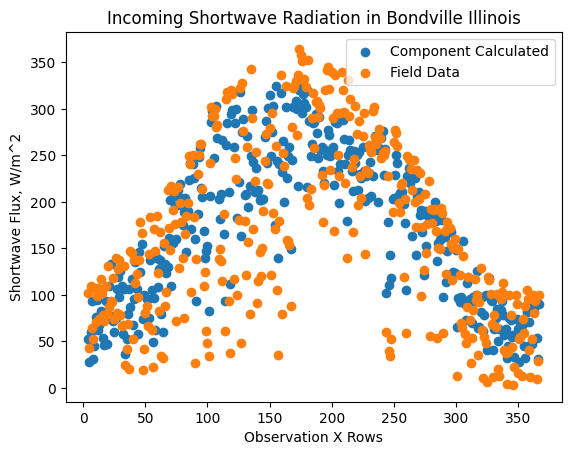

In [ ]:
# Open the Excel file
bondville_book = xlrd.open_workbook("../Field Data/Bondville_IL_2003.xls")
# Get the specified sheet by name
sheet = bondville_book.sheet_by_name("Sheet1")
limit = 368
def get_column_vals(column):
    # Initialize an empty list to store the data values
    data_values = []
    # Iterate through the rows and retrieve the data values from column E
    for row in range(4, limit):  # Rows 5 to 369 (0-indexed)
        cv = sheet.cell_value(row, column)
        if (type(cv) == type(0.00)):
            data_values.append(sheet.cell_value(row, column))  # Column E (0-indexed)
        else:
            data_values.append(350.0)
    return data_values
    
def get_max_temperatures():
    return get_column_vals(4)

def get_min_temperatures():
    return get_column_vals(5)

# Bondville Illinois latitude and elevation here
bondville_lat = 40.0667

field_plot = get_column_vals(10)
calculated_plot = []

max_temps = get_max_temperatures()
min_temps = get_min_temperatures()
designated_month_index = 0
avg_deviation = 0

# Calculate all shortwave data points using excel Tmin and Tmax inputs
for row in range (4, limit):
    # Retrieve the max daily temp and min daily temps using the excel data buffer
    bondville_Tmax = max_temps[row-4]
    bondville_Tmin = min_temps[row-4]

    # Row ultimately represents the day. Multiplying the day by (1/365) to match the 0.0-1.0
    # numeric range of current_time in the rad component gets us a good current day.
    designated_month_index = ((row-4) * 0.002739)
    # Instantiate bondville radiation component
    bondville_rad = Radiation(watershed, 
                            method='Grid', 
                            albedo=0.25,  
                            current_time=(designated_month_index), 
                            kt=0.2,
                            latitude=bondville_lat, 
                            min_daily_temp=bondville_Tmin, 
                            max_daily_temp=bondville_Tmax)

    bondville_rad.update()
    # Append average shortwave radiation flux to the calculated_plot field
    avg_shortwave = np.average(bondville_rad._cell_values['radiation__incoming_shortwave_flux'])
    # avg_shortwave = bondville_rad._Rs
    calculated_plot.append(avg_shortwave)
    
# Render the results
plt.figure();
fig, axes = plt.subplots()

# Set labels
axes.set_xlabel("Observation X Rows")
axes.set_ylabel("Shortwave Flux, W/m^2")
axes.set_title("Incoming Shortwave Radiation in Bondville Illinois")

# Plot both the calculated functions and the actual field observations
axes.scatter(range(4, limit), calculated_plot)
axes.scatter(range(4, limit), field_plot)

# Add legends
axes.legend(['Component Calculated', 'Field Data'])

Fairly similar results, and for clarification, we are taking the radiation flux calculations before spatial distribution is applied to the elevation model because Bondville is essentially a plateau landscape, and it wouldn't make sense to test the accuracy of the component from how the radiation is mapped on a spatial distribution that doesn't generally match the surface of where the field data was recorded. However it's important to be as precise and diligent as we can so let's make some regression models and run some more tests to really confirm model reliability.

#### RADIATION COMPONENT TESTING PART I.

This cell calculates the root mean squared error, Nash Sutcliffe Efficiency, and R-squared
values with STRICTLY the NEW RADIATION COMPONENT-CALCULATED DATA and the Bondville EXCEL FIELD DATA.
There is ZERO Linear Regression involved in ANY of the outputs in this cell of the notebook.
The results here are only derived from raw calculated data points being passed as a "predictions"
field against raw observed data points which are being passed as parts of an "observations" field.

NASH SUTCLIFFE ERROR:  0.7501354586178295
ROOT MEAN SQUARED:  47.220622926278594


<Figure size 640x480 with 0 Axes>

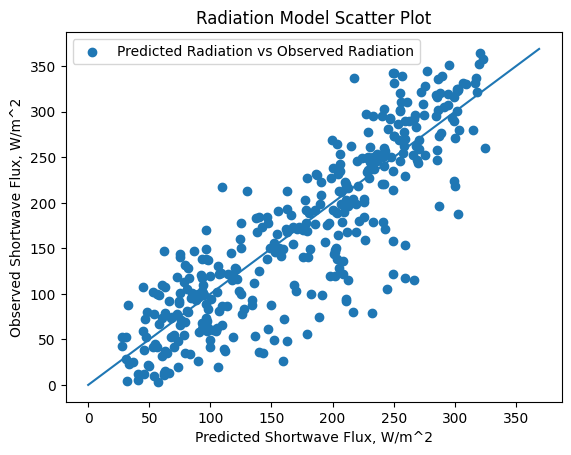

In [7]:
# Store calculated and observed value fields in numpy array
x = np.array(calculated_plot)
y = np.array(field_plot)

# Calculate all statistical variables
nash_sutcliffe = nse(y, x)
rmse_val = rmse(y, x)

# Create a 1:1 slope line
one_line = np.poly1d([1, 0])
# Print all stats
print("NASH SUTCLIFFE ERROR: ", nash_sutcliffe)
print("ROOT MEAN SQUARED: ", rmse_val)

# SHORTWAVE RAD
plt.figure();
fig, axes = plt.subplots()

# Set labels
axes.set_xlabel("Predicted Shortwave Flux, W/m^2")
axes.set_ylabel("Observed Shortwave Flux, W/m^2")
axes.set_title("Radiation Model Scatter Plot")

# Plot both the calculated functions and the actual field observations
axes.scatter(x, y)
axes.plot(range(370), one_line(range(370)))
#axes.plot(x, [num - 47.366 for num in y_pred], 'r')

# Add legends
axes.legend(['Predicted Radiation vs Observed Radiation'])


The NSE value being nearly 0.75 indicates great model correlation. While the RMSE seems more problematic, a 47W/m^2 variance is mostly due to not having precision inputs for many of the other factors the component takes into account (e.g the precise albedo, cloudiness, turbidity and optical airmass of Bondville), and it won't make a world of difference intensity-wise especially on a grid where the predicted values (relative to each other as a whole) will still be fairly representative of real radiation flux and the magnitude of that radiation across a grid of different elevations.